# P5 - Segmentez les comportements de clients
___

Le travail s'effectue sur une base de donnée comportant les transactions d'une année de ventes.

L'objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement dans la durée, afin de détecter les plus susceptibles de passer à l'achat.
___



## 1. Récupération et visualisation globale des données

In [1]:
import pandas as pd
import numpy as np
import datetime
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Récupération du fichier en local
CT_DIR_DATA = 'C:\Work\OpenClassrooms\data\P5/'
df = pd.read_excel(CT_DIR_DATA + 'Online Retail.xlsx')

In [3]:
# Desciption du dataset
print('Nombre de lignes :', df.shape[0])
print('Nombre de features :', df.shape[1])
df.head()

Nombre de lignes : 541909
Nombre de features : 8


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
print('Début :', df.InvoiceDate.min())
print('Fin :', df.InvoiceDate.max())

Début : 2010-12-01 08:26:00
Fin : 2011-12-09 12:50:00


In [5]:
# Quantité des différentes éléments
pd.DataFrame([{'Produits': df['StockCode'].nunique(),    
               'Transactions': df['InvoiceNo'].nunique(),
               'Clients': df['CustomerID'].nunique(),  
               'Pays': df['Country'].nunique(),  
              }], columns = ['Produits', 'Transactions', 'Clients', 'Pays'], index = ['Quantité'])

,Produits,Transactions,Clients,Pays
Quantité,4070,25900,4372,38


## 2. Analyse univariée des données

### 2.1 Les valeurs manquantes et les doublons

#### 2.1.1 Etude des valeurs manquantes

In [6]:
# Description des features et valeurs manquantes
tab_info = pd.DataFrame(df.dtypes).T.rename(index={0:'Type'})
tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'Valeurs manquantes (nb)'}))
tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'Valeurs manquantes (%)'}))
display(tab_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Type,object,object,object,int64,datetime64[ns],float64,float64,object
Valeurs manquantes (nb),0,0,1454,0,0,0,135080,0
Valeurs manquantes (%),0,0,0.268311,0,0,0,24.9267,0


Il y a quand même 25% des lignes pour lesquelles l'identifiant client n'est pas renseigné, on pourrait se demander pourquoi il y en a autant, mais étant donné qu'on veut travailler sur la segmentation des clients leur identification est indispensable, on supprime donc les lignes dont l'id de clients est manquant.

In [7]:
df = df[pd.notnull(df['CustomerID'])]
print(df.shape)

(406829, 8)


#### 2.1.2 Etude des doublons

In [8]:
print("Il y a", str(df.duplicated().sum()), "doublons")
#df.drop_duplicates(inplace = True)

Il y a 5225 doublons


Le premier réflexe serait d'enlever les doublons mais j'ai eu un doute en pensant aux différentes façons de remplir un panier sur un site internet, et aussi aux différentes manières de faire des lots (par cartons, par palettes...). Du coup je garde les doublons tels quels, le client pourra confirmer ou infirmer et je corrigerai le cas échéant.


### 2.2 Les quantités négatives

In [9]:
print(df[df.Quantity <= 0].shape[0], 'lignes dont la quantité est négative')

df[df.Quantity <= 0].sort_values('InvoiceNo').head()

8905 lignes dont la quantité est négative


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


Il semble que cela corresponde à des annulations de commande, notons cette feature 'Cancel'

In [10]:
df[df['InvoiceNo'].str.startswith('C', na=False)].shape

(8905, 8)

Toutes ces lignes correspondent à une facture commençant par 'C', on va pouvoir créer une feature pour marquer les annulations de commande

In [11]:
df['Cancel'] = 0
df.loc[df.Quantity <= 0, 'Cancel'] = 1

### 2.3 Les prix nuls

In [12]:
print(df[df.UnitPrice == 0].shape[0], 'lignes dont le prix est nul')

df[df.UnitPrice == 0].sort_values('InvoiceNo').head()

40 lignes dont le prix est nul


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany,0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom,0
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE,0
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,0
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,0


Ici cela semble correspondre à des promotions, notons cette feature 'Promo'

In [13]:
df['Promo'] = 0
df.loc[df.UnitPrice == 0, 'Promo'] = 1

### 2.4 Les pays

In [14]:
print(df.Country.nunique(), 'pays sont représentés')

37 pays sont représentés


In [15]:
df_country = df[['Country','CustomerID']].drop_duplicates()
df_country = df_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)
df_country

,Country,CustomerID
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


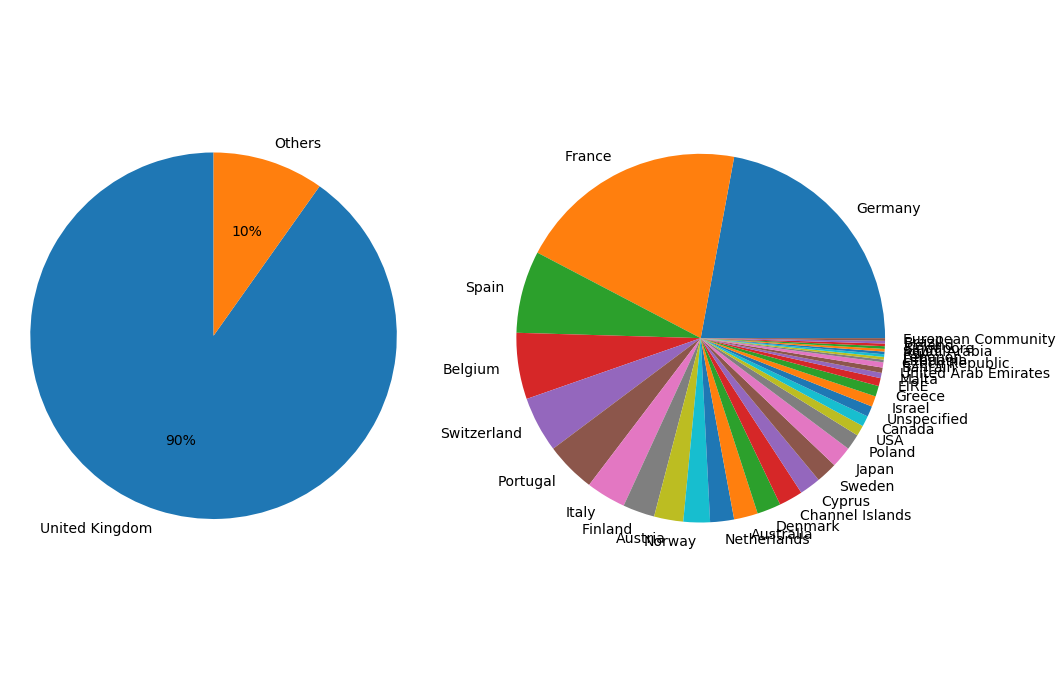

In [16]:
plt.rc('font', weight='normal', size=14)

fig = plt.figure(figsize=(16,12))

ax = fig.add_subplot(121)
nbUK = df_country[df_country.Country=='United Kingdom'].CustomerID.sum()
nbOthers = df_country[df_country.Country!='United Kingdom'].CustomerID.sum()
ax.pie([nbUK, nbOthers], labels=['United Kingdom', 'Others'], autopct = lambda x:'{:1.0f}%'.format(x), startangle=90)
ax.axis('equal')

ax = fig.add_subplot(122)
df_country_others = df_country[df_country.Country!='United Kingdom']
ax.pie(df_country_others.CustomerID, labels=df_country_others.Country)
ax.axis('equal')
plt.show()

Comme on peut le voir les achat en provenance de UK sont très majoritaires.

On peut dans un premier temps simplifier cette donnée en par la feature 'UK' valant 1 pour un achat en provenance du Royaume Uni et 0 sinon 

In [17]:
df['UK'] = 1
df.loc[df.Country != 'United Kingdom', 'UK'] = 0

### 2.5 Prix total

Pour chaque ligne on peut ajouter le prix total, ce qui va nous permettre d'estimer les montants dépensés par chaque client

In [18]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,Promo,UK,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,0,1,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0,1,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,0,1,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0,1,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0,1,20.34


### 2.6 Codes

Les codes ne correspondent pas tous à des produits, certains commençant par une lettre désignent différents types de transactions, commençons par les lister:

In [19]:
lst_codes = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True, na=False)==True]['StockCode'].unique()
for code in lst_codes:
    display(df[df.StockCode == code].head())


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,Promo,UK,TotalPrice
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.0,12583.0,France,0,0,0,54.0
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.0,12791.0,Netherlands,0,0,0,15.0
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.0,12662.0,Germany,0,0,0,18.0
5073,536840,POST,POSTAGE,1,2010-12-02 18:27:00,18.0,12738.0,Germany,0,0,0,18.0
5258,536852,POST,POSTAGE,1,2010-12-03 09:51:00,18.0,12686.0,France,0,0,0,18.0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,Promo,UK,TotalPrice
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,1,0,1,-27.50
9038,C537164,D,Discount,-1,2010-12-05 13:21:00,29.29,14527.0,United Kingdom,1,0,1,-29.29
14498,C537597,D,Discount,-1,2010-12-07 12:34:00,281.00,15498.0,United Kingdom,1,0,1,-281.00
19392,C537857,D,Discount,-1,2010-12-08 16:00:00,267.12,17340.0,United Kingdom,1,0,1,-267.12
31134,C538897,D,Discount,-1,2010-12-15 09:14:00,5.76,16422.0,United Kingdom,1,0,1,-5.76


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,Promo,UK,TotalPrice
1423,536540,C2,CARRIAGE,1,2010-12-01 14:05:00,50.0,14911.0,EIRE,0,0,0,50.0
12119,537368,C2,CARRIAGE,1,2010-12-06 12:40:00,50.0,14911.0,EIRE,0,0,0,50.0
12452,537378,C2,CARRIAGE,1,2010-12-06 13:06:00,50.0,14911.0,EIRE,0,0,0,50.0
19975,537963,C2,CARRIAGE,1,2010-12-09 11:30:00,50.0,13369.0,United Kingdom,0,0,1,50.0
20016,538002,C2,CARRIAGE,1,2010-12-09 11:48:00,50.0,14932.0,Channel Islands,0,0,0,50.0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,Promo,UK,TotalPrice
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274.0,United Kingdom,0,0,1,1.25
2250,536569,M,Manual,1,2010-12-01 15:35:00,18.95,16274.0,United Kingdom,0,0,1,18.95
6798,536981,M,Manual,2,2010-12-03 14:26:00,0.85,14723.0,United Kingdom,0,0,1,1.70
7976,537077,M,Manual,12,2010-12-05 11:59:00,0.42,17062.0,United Kingdom,0,0,1,5.04
8530,537137,M,Manual,36,2010-12-05 12:43:00,0.85,16327.0,United Kingdom,0,0,1,30.60


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,Promo,UK,TotalPrice
4406,536779,BANK CHARGES,Bank Charges,1,2010-12-02 15:08:00,15.0,15823.0,United Kingdom,0,0,1,15.0
62508,541505,BANK CHARGES,Bank Charges,1,2011-01-18 15:58:00,15.0,15939.0,United Kingdom,0,0,1,15.0
152966,549717,BANK CHARGES,Bank Charges,1,2011-04-11 14:56:00,15.0,14606.0,United Kingdom,0,0,1,15.0
175275,551945,BANK CHARGES,Bank Charges,1,2011-05-05 11:09:00,15.0,16714.0,United Kingdom,0,0,1,15.0
327921,565735,BANK CHARGES,Bank Charges,1,2011-09-06 12:25:00,15.0,16904.0,United Kingdom,0,0,1,15.0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,Promo,UK,TotalPrice
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-04-15 09:27:00,0.001,13952.0,United Kingdom,0,0,1,0.001
279045,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-07-26 10:13:00,0.001,15618.0,United Kingdom,0,0,1,0.001
358655,568158,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-09-25 12:22:00,0.000,16133.0,United Kingdom,0,1,1,0.000
359871,568200,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-09-25 14:58:00,0.001,16198.0,United Kingdom,0,0,1,0.001


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,Promo,UK,TotalPrice
317507,564764,DOT,DOTCOM POSTAGE,1,2011-08-30 10:49:00,11.17,14096.0,United Kingdom,0,0,1,11.17
324002,565383,DOT,DOTCOM POSTAGE,1,2011-09-02 15:45:00,16.46,14096.0,United Kingdom,0,0,1,16.46
333755,566217,DOT,DOTCOM POSTAGE,1,2011-09-09 15:17:00,13.16,14096.0,United Kingdom,0,0,1,13.16
338829,566566,DOT,DOTCOM POSTAGE,1,2011-09-13 12:32:00,85.58,14096.0,United Kingdom,0,0,1,85.58
350599,567656,DOT,DOTCOM POSTAGE,1,2011-09-21 14:40:00,878.55,14096.0,United Kingdom,0,0,1,878.55


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,Promo,UK,TotalPrice
317508,C564763,CRUK,CRUK Commission,-1,2011-08-30 10:49:00,1.60,14096.0,United Kingdom,1,0,1,-1.60
324023,C565382,CRUK,CRUK Commission,-1,2011-09-02 15:45:00,13.01,14096.0,United Kingdom,1,0,1,-13.01
333779,C566216,CRUK,CRUK Commission,-1,2011-09-09 15:17:00,15.96,14096.0,United Kingdom,1,0,1,-15.96
338848,C566565,CRUK,CRUK Commission,-1,2011-09-13 12:32:00,52.24,14096.0,United Kingdom,1,0,1,-52.24
351003,C567655,CRUK,CRUK Commission,-1,2011-09-21 14:40:00,608.66,14096.0,United Kingdom,1,0,1,-608.66


### 2.6.1 Code POST

In [20]:
code = 'POST'
df[df.StockCode == code].Country.unique()

array(['France', 'Netherlands', 'Germany', 'Switzerland', 'Portugal',
       'Italy', 'Belgium', 'United Kingdom', 'Denmark', 'Spain', 'Finland',
       'Austria', 'Sweden', 'Norway', 'Cyprus', 'Australia', 'Greece',
       'European Community', 'Poland', 'Malta', 'Canada',
       'United Arab Emirates', 'Czech Republic'], dtype=object)

Le code POST correspond à des frais postaux, il y en a même en UK, on peut l'utiliser comme nouvelle feature

In [21]:
df['CODE_' + code] = 0
df.loc[df.StockCode == code, 'CODE_' + code] = 1

### 2.6.2 Code D

In [22]:
code = 'D'
print(df[(df.StockCode == code)].shape)
print(df[(df.StockCode == code) & (df['InvoiceNo'].str.startswith('C', na=False))].shape)

(77, 13)
(77, 13)


Le code D correspond à du discount, ils sont déjà tous noté 'Cancel' mais n'en forment qu'une petite partie, on va là aussi créer une nouvelle feature

In [23]:
df['CODE_' + code] = 0
df.loc[df.StockCode == code, 'CODE_' + code] = 1

### 2.6.3 Code C2

Le code C2 (pour CARRIAGE) semble être une sorte de frais de transport, gardons le

In [24]:
code = 'C2'
df['CODE_' + code] = 0
df.loc[df.StockCode == code, 'CODE_' + code] = 1

### 2.6.4 Code M

Le code M (pour MANUAL) semble être une sorte de frais de transport aussi, gardons

In [25]:
code = 'M'
df['CODE_' + code] = 0
df.loc[df.StockCode == code, 'CODE_' + code] = 1

### 2.6.5 Code BANK CHARGES

Trop peu d'occurrences

### 2.6.6 Code PADS

Le code PADS ne concerne que 4 lignes, pour des sommes dérisoires, il ne semble pas utile de s'en occuper à notre niveau

### 2.6.7 Code DOT

DOT (pour DOTCOM POSTAGE) : trop peu d'occurrences

### 2.6.8 Code CRUK

Le code CRUK (Cancer Research UK commission) correspond à des sommes données en faveur de la recherche contre le cancer, cette feature est intéressante pour caractériser un client, le problème est qu'elle ne concerne qu'un seul client ! Pas d'intérêt pour nous donc  :(

## 3. Regroupement des features par client

### 3.1 Création de la table RFM

La table RFM (récence, fréquence, valeur) est la base de la segmentation client, elle permet de catégoriser les clients selon des critères simples, le client est-il régulier ? Dépense-t-il beacoup d'argent ? ...

On va créer une méthode de construction de cette table RFM en fonction de la date à laquelle on veut étudier les données.

On ajoute aussi les nouvelles feature vues précédemment.

In [26]:
import datetime as dt

def getRScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def getFMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
# Méthode de création d'un table RFM à partir d'un dataframe
def getRFM(p_df):
    # Référence pour calculer la récence
    # On prends la dernière date du dataframe et on ajoute un jour
    dtmax = p_df.InvoiceDate.max()
    NOW = dt.datetime(dtmax.year, dtmax.month, dtmax.day) + datetime.timedelta(days=1)
    print('Date de référence :', NOW)

    ret = p_df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (NOW - x.max()).days, 
                                         'InvoiceNo': lambda x: len(x), 
                                         'TotalPrice': lambda x: x.sum(),
                                         'Cancel': lambda x: x.sum(),
                                         'Promo': lambda x: x.sum(),
                                         'UK': lambda x: 1 if (x.all()>0) else 0,
                                         'CODE_POST': lambda x: x.sum(),
                                         'CODE_D': lambda x: x.sum(),
                                         'CODE_C2': lambda x: x.sum(),
                                         'CODE_M': lambda x: x.sum(),
                                                        })
    # Un prix total négatif correspond certainement à des retours clients dont l'achat n'était pas dans la base, on le met à 0
    ret.loc[ret.TotalPrice < 0, 'TotalPrice'] = 0
    # La date est maintenant un nombre de jours
    ret['InvoiceDate'] = ret['InvoiceDate'].astype(int)
    # On peut renommer les colonnes pour plus de clarté
    ret.rename(columns = {'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'TotalPrice': 'monetary_value',
                         'CODE_D': 'CODE_DISCOUNT',
                         'CODE_C2': 'CODE_CARRIAGE',
                         'CODE_M': 'CODE_MANUAL',
                         }, inplace=True)
    
    quantiles = ret.quantile(q=[0.25,0.5,0.75])
    quantiles = quantiles.to_dict()
    
    ret['r_quartile'] = ret['recency'].apply(getRScore, args=('recency',quantiles))
    ret['f_quartile'] = ret['frequency'].apply(getFMScore, args=('frequency',quantiles))
    ret['m_quartile'] = ret['monetary_value'].apply(getFMScore, args=('monetary_value',quantiles))

    ret['RFMScore'] = ret.r_quartile.map(str) + ret.f_quartile.map(str) + ret.m_quartile.map(str)

    return ret

In [27]:
# RFM
rfmTable = getRFM(df)
display(rfmTable.head())
rfmTable.describe()

Date de référence : 2011-12-10 00:00:00


,recency,frequency,monetary_value,Cancel,Promo,UK,CODE_POST,CODE_DISCOUNT,CODE_CARRIAGE,CODE_MANUAL,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,,,,,,,
12346.0,325,2,0.00,1,0,1,0,0,0,0,4,4,4,444
12347.0,2,182,4310.00,0,0,0,0,0,0,0,1,1,1,111
12348.0,75,31,1797.24,0,0,0,4,0,0,0,3,3,1,331
12349.0,18,73,1757.55,0,0,0,1,0,0,0,2,2,1,221
12350.0,310,17,334.40,0,0,0,1,0,0,0,4,4,3,443


,recency,frequency,monetary_value,Cancel,Promo,UK,CODE_POST,CODE_DISCOUNT,CODE_CARRIAGE,CODE_MANUAL,r_quartile,f_quartile,m_quartile
count,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000
mean,91.581199,93.053294,1901.485580,2.036825,0.009149,0.903477,0.273559,0.017612,0.030650,0.106359,2.489021,2.512580,2.500000
std,100.772139,232.471608,8218.276346,7.340449,0.126218,0.295341,1.449589,0.558957,1.305348,0.655397,1.117084,1.119114,1.118162
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,16.000000,17.000000,293.362500,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.750000
50%,50.000000,42.000000,648.075000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,2.500000
75%,143.000000,102.000000,1611.725000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,4.000000,3.250000
max,373.000000,7983.000000,279489.020000,226.000000,4.000000,1.000000,33.000000,35.000000,85.000000,17.000000,4.000000,4.000000,4.000000


### 3.2 Analyse de la table RFM

#### 3.2.1 Les meilleurs clients selon la table RFM

In [28]:
# Les meilleurs clients
rfmTable[rfmTable['RFMScore']=='111'].sort_values('monetary_value', ascending=False).head(20)

,recency,frequency,monetary_value,Cancel,Promo,UK,CODE_POST,CODE_DISCOUNT,CODE_CARRIAGE,CODE_MANUAL,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,,,,,,,
14646.0,1,2085,279489.02,5,4,0,17,1,0,1,1,1,1,111
18102.0,0,433,256438.49,2,0,1,0,0,0,2,1,1,1,111
17450.0,8,351,187482.17,14,0,1,6,1,0,4,1,1,1,111
14911.0,1,5903,132572.62,226,2,0,0,1,85,4,1,1,1,111
14156.0,9,1420,113384.14,20,0,0,0,0,13,1,1,1,1,111
17511.0,2,1076,88125.38,113,0,1,1,0,0,1,1,1,1,111
16684.0,4,281,65892.08,4,0,1,0,1,0,0,1,1,1,111
13694.0,3,585,62653.10,17,0,1,0,2,0,1,1,1,1,111
15311.0,0,2491,59419.34,112,0,1,0,0,0,0,1,1,1,111


#### 3.2.2 Les meilleurs clients selon le chiffre d'affaire

439 clients apportent 60% du CA


Text(1000,50,'10% des clients, 60% du CA')

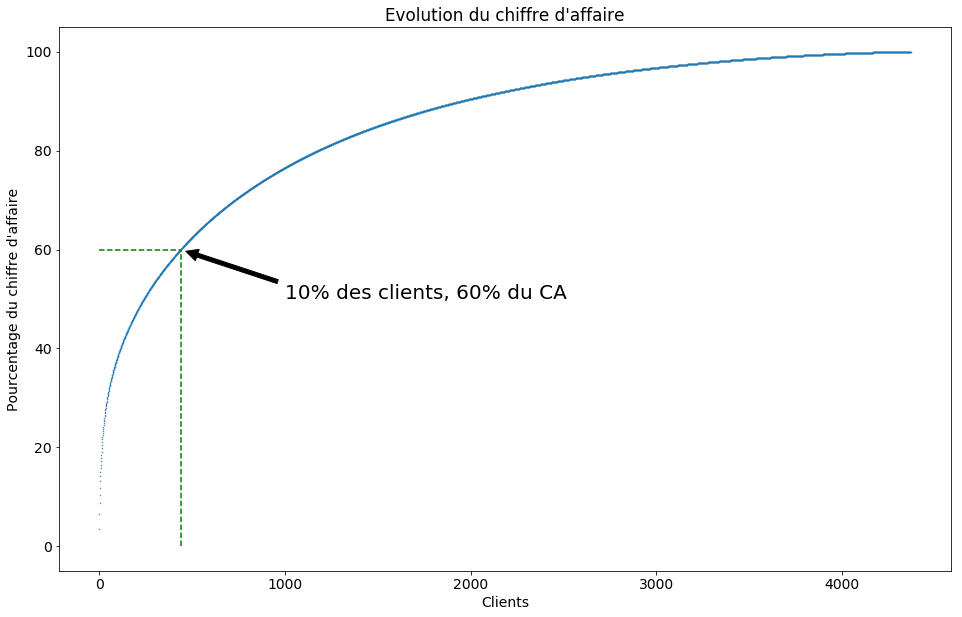

In [29]:
# Recherche des plus gros apporteurs de chiffre
rfmBest = rfmTable.copy()
rfmBest = rfmBest.sort_values('monetary_value', ascending=False)
rfmBest['cum_sum'] = rfmBest.monetary_value.cumsum()
rfmBest['cum_perc'] = 100 * rfmBest.cum_sum / rfmBest.monetary_value.sum()

nb_best_customers = rfmBest[rfmBest['cum_perc']<60].shape[0]

print(nb_best_customers, 'clients apportent 60% du CA')

# 60% du CA par 10% des clients (à peu près 400)

fig, ax = plt.subplots(figsize=(16,10))
plt.scatter(range(0, len(rfmBest['cum_sum'])), rfmBest['cum_perc'], s=0.2)
plt.plot((0, nb_best_customers), (60, 60), '--', c='g')
plt.plot((nb_best_customers, nb_best_customers), (0, 60), '--', c='g')
plt.xlabel("Clients")
plt.ylabel("Pourcentage du chiffre d'affaire")
plt.title("Evolution du chiffre d'affaire")
plt.annotate('10% des clients, 60% du CA', xy=(nb_best_customers, 60), xytext=(1000, 50), fontsize=20,
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

Comme dans la plupart des cas, une grosse partie du CA est apportée par une petite partie des clients.

Ce graphique est intéressant visuellement mais tous ces clients sont déjà catégorisé par la table RFM, on n'ajoutera donc pas de nouvelle feature ici.

#### 3.2.3 Visualisation 3D

On va essayer de visualiser ces données en 3D, pour cela on doit prendre le log des prix pour réduire l'échelle.

Text(0.5,0,'Valeur (log)')

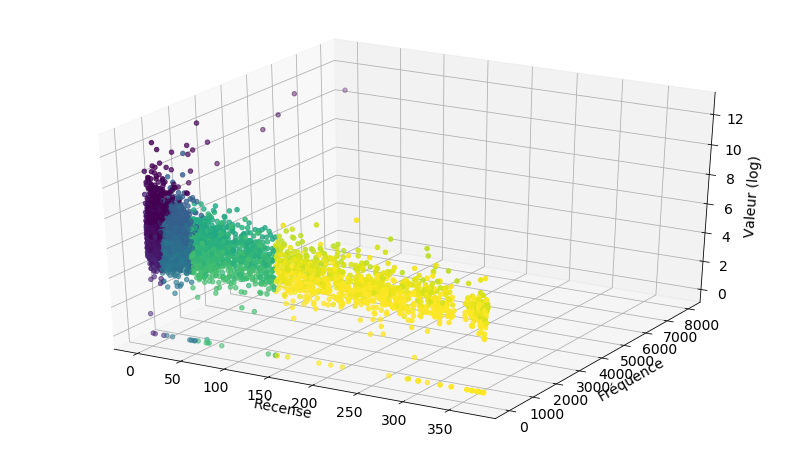

In [30]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(14, 8))
ax = plt.axes(projection='3d')
ax.scatter(rfmTable.recency, rfmTable.frequency, np.log(rfmTable.monetary_value+1), c=rfmTable.RFMScore)
plt.ylabel('Fréquence')
plt.xlabel('Récense')
ax.set_zlabel('Valeur (log)')
#plt.gca().invert_xaxis()
#plt.gca().invert_yaxis()

#### 3.2.4 ACP et Scree plot

Procédons maintenant à une analyse en composantes principales

[ 0.27436653  0.15345714  0.11637078  0.08145553  0.07259757  0.0672023
  0.06433071  0.04403476  0.0380122   0.03223084  0.02712969  0.01839438
  0.01041756]


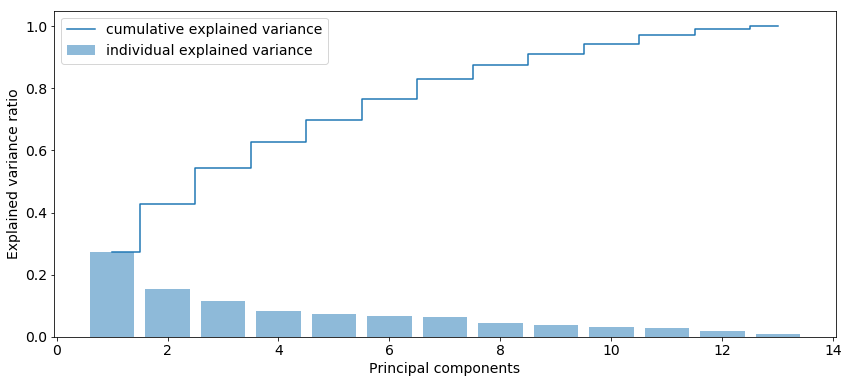

In [31]:
from sklearn import preprocessing
from sklearn import decomposition

rfmPCA = rfmTable.copy()
rfmPCA.pop('RFMScore')

std_scale = preprocessing.StandardScaler().fit(rfmPCA)
X_scaled = std_scale.transform(rfmPCA)

pca = decomposition.PCA(n_components=None)
pca.fit(X_scaled)

print (pca.explained_variance_ratio_)

fig, ax = plt.subplots(figsize=(14, 6))
plt.bar(range(1,14), pca.explained_variance_ratio_, alpha = 0.5, align = 'center', label = 'individual explained variance')
plt.step(range(1,14), np.cumsum(pca.explained_variance_ratio_), where = 'mid', label = 'cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc = 'best')
plt.show()

Les deux principales composantes expliquent environ 43% de la variance.

On arrive au dessus de 80% de variance expliquée à partir de 7 composantes, et à partir de là, chaque composante supplémentaire apporte moins de 5% d'explication de variance en plus.

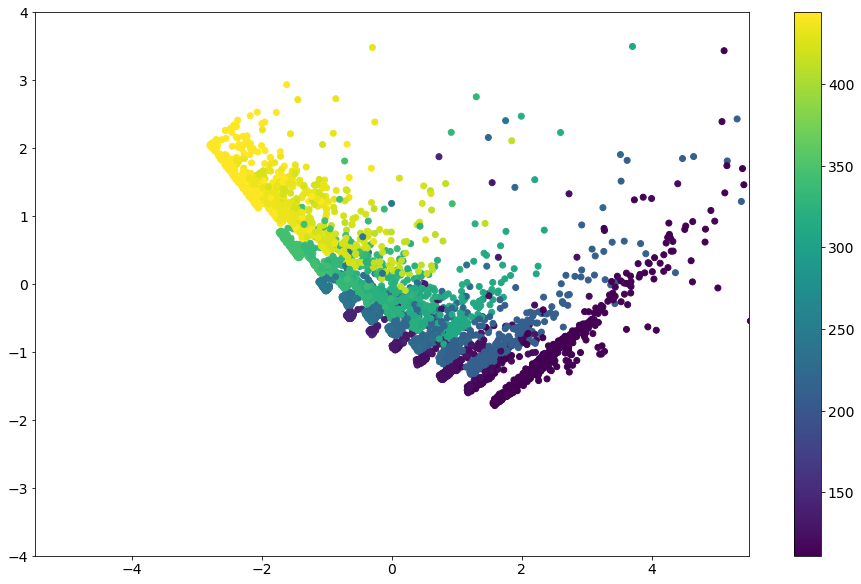

In [32]:
# projeter X sur les composantes principales
X_projected = pca.transform(X_scaled)
# afficher chaque observation
fig = plt.figure(figsize=(16, 10))
plt.scatter(X_projected[:, 0], X_projected[:, 1],
# colorer en utilisant la variable 'RFMScore'
c = rfmTable.get('RFMScore'))
plt.xlim([-5.5, 5.5])
plt.ylim([-4, 4])
plt.colorbar()

(-0.7, 0.7)

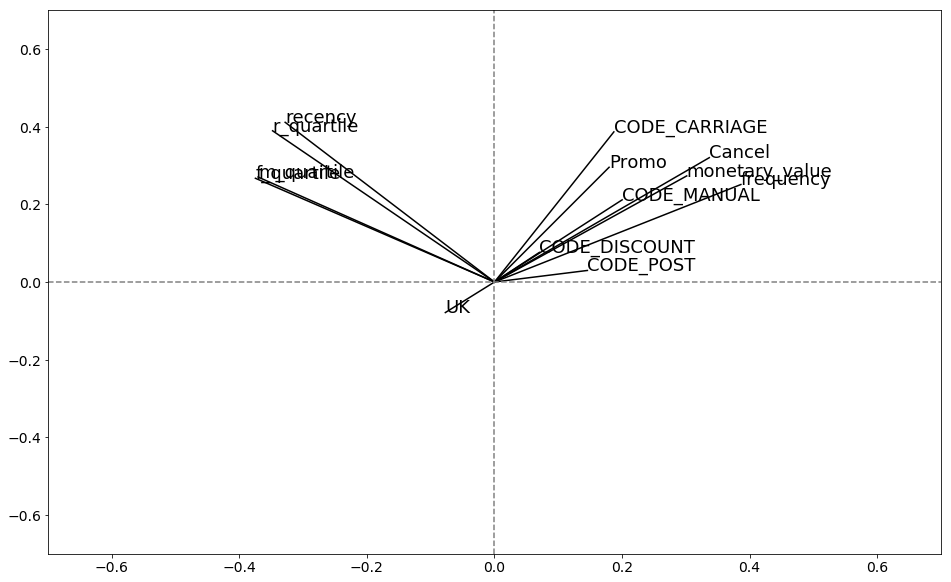

In [33]:
pcs = pca.components_
fig = plt.figure(figsize=(16, 10))
for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, rfmPCA.columns[i], fontsize='18')
# Afficher une ligne horizontale y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')
# Afficher une ligne verticale x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')
plt.xlim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])

## 4. Historique des achats par client

L'idée ici est d'avoir des données pour chaque client mois par mois ou semaine par semaine s'il le faut, on ajoute donc quelques features pour détailler la date de chaque facture

In [34]:
pd.set_option('display.max_columns', 150)

tmp = df.copy()
tmp['InvoiceDateYM'] = tmp.apply(lambda row: str(row['InvoiceDate'].year) + '-' + str(row['InvoiceDate'].month), axis=1)
tmp['InvoiceDateYW'] = tmp.apply(lambda row: str(row['InvoiceDate'].year) + '-' + str(row['InvoiceDate'].week), axis=1)
tmp.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,Promo,UK,TotalPrice,CODE_POST,CODE_D,CODE_C2,CODE_M,InvoiceDateYM,InvoiceDateYW
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,0,1,15.30,0,0,0,0,2010-12,2010-48
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0,1,20.34,0,0,0,0,2010-12,2010-48
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,0,1,22.00,0,0,0,0,2010-12,2010-48
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0,1,20.34,0,0,0,0,2010-12,2010-48
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0,1,20.34,0,0,0,0,2010-12,2010-48


In [ ]:
# On va aggréger selon ces features:
aggreg = {
    'Quantity':[
        'sum',
        'max',
        'min'
    ],
    'TotalPrice':[
        'sum',
        'max',
        'min'
    ]
}
groups = ['CustomerID', 'InvoiceDateYM']

### 4.1 Historique mensuel

In [85]:
# Aggrégation
dfhisto = tmp.groupby(groups).agg(aggreg).unstack()

# Target
dfhisto['target'] = (dfhisto[('TotalPrice', 'sum', '2011-11')] > 0)

# Mois de la target
dfhisto.drop('2011-11', level=2, axis=1, inplace=True)
# Mois incomplet
dfhisto.drop('2011-12', level=2, axis=1, inplace=True)

print(dfhisto.shape)
dfhisto.head()
# On essayera donc de prédire les achats au mois de novembre 2011

(4372, 67)


Quantity                                                    \
                   sum                                                     
InvoiceDateYM  2010-12 2011-1 2011-10 2011-2 2011-3 2011-4 2011-5 2011-6   
CustomerID                                                                 
12346.0            NaN    0.0     NaN    NaN    NaN    NaN    NaN    NaN   
12347.0          319.0  315.0   676.0    NaN    NaN  483.0    NaN  196.0   
12348.0         1254.0  601.0     NaN    NaN    NaN  269.0    NaN    NaN   
12349.0            NaN    NaN     NaN    NaN    NaN    NaN    NaN    NaN   
12350.0            NaN    NaN     NaN  197.0    NaN    NaN    NaN    NaN   

                                                                           \
                                       max                                  
InvoiceDateYM 2011-7 2011-8 2011-9 2010-12   2011-1 2011-10 2011-2 2011-3   
CustomerID                                                                  
12346.0          NaN    NaN    NaN     NaN  74215.0     NaN    NaN    NaN   
12347.0          NaN  277.0    NaN    36.0     24.0    48.0    NaN    NaN   
12348.0          NaN    NaN  217.0   144.0    144.0     NaN    NaN    NaN   
12349.0          NaN    NaN    NaN     NaN      NaN     NaN    NaN    NaN   
12350.0          NaN    NaN    NaN     NaN      NaN     NaN   24.0    NaN   

                                                                          \
                                                            min            
InvoiceDateYM 2011-4 2011-5 2011-6 2011-7 2011-8 2011-9 2010-12   2011-1   
CustomerID                                                                 
12346.0          NaN    NaN    NaN    NaN    NaN    NaN     NaN -74215.0   
12347.0        240.0    NaN   36.0    NaN   36.0    NaN     3.0      3.0   
12348.0         96.0    NaN    NaN    NaN    NaN  120.0     6.0      1.0   
12349.0          NaN    NaN    NaN    NaN    NaN    NaN     NaN      NaN   
12350.0          NaN    NaN    NaN    NaN    NaN    NaN     NaN      NaN   

                                                                               \
                                                                                
InvoiceDateYM 2011-10 2011-2 2011-3 2011-4 2011-5 2011-6 2011-7 2011-8 2011-9   
CustomerID                                                                      
12346.0           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12347.0           2.0    NaN    NaN    3.0    NaN    2.0    NaN    3.0    NaN   
12348.0           NaN    NaN    NaN    1.0    NaN    NaN    NaN    NaN    1.0   
12349.0           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
12350.0           NaN    1.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

              TotalPrice                                                \
                     sum                                                 
InvoiceDateYM    2010-12  2011-1  2011-10 2011-2 2011-3  2011-4 2011-5   
CustomerID                                                               
12346.0              NaN    0.00      NaN    NaN    NaN     NaN    NaN   
12347.0           711.79  475.39  1294.32    NaN    NaN  636.25    NaN   
12348.0           892.80  227.44      NaN    NaN    NaN  367.00    NaN   
12349.0              NaN     NaN      NaN    NaN    NaN     NaN    NaN   
12350.0              NaN     NaN      NaN  334.4    NaN     NaN    NaN   

                                                                              \
                                                max                            
InvoiceDateYM  2011-6 2011-7  2011-8 2011-9 2010-12    2011-1 2011-10 2011-2   
CustomerID                                                                     
12346.0           NaN    NaN     NaN    NaN     NaN  77183.60     NaN    NaN   
12347.0        382.52    NaN  584.91    NaN    70.8     38.25   106.2    NaN   
12348.0           NaN    NaN     NaN  310.0   240.0     41.76     NaN    

In [59]:
dfhisto = tmp.groupby(['CustomerID', 'InvoiceDateYM']).agg({
            'Quantity': lambda x: x.sum(),
            'TotalPrice': lambda x: x.sum()
      }).unstack()

# Le dernier mois n'étant pas complet on ne va pas l'utiliser pour définir notre modèle
#dfhisto = dfhisto.iloc[:, :-1]
dfhisto.drop(('TotalPrice', '2011-12'), axis = 1, inplace = True)
dfhisto.drop(('Quantity', '2011-12'), axis = 1, inplace = True)

# On ne garde pas non plus les features redondante avec la target
dfhisto.drop(('Quantity', '2011-11'), axis = 1, inplace = True)

print(dfhisto.shape)
dfhisto.head()
# On essayera donc de prédire les achats au mois de novembre 2011

(4372, 23)


Quantity                                                    \
InvoiceDateYM  2010-12 2011-1 2011-10 2011-2 2011-3 2011-4 2011-5 2011-6   
CustomerID                                                                 
12346.0            NaN    0.0     NaN    NaN    NaN    NaN    NaN    NaN   
12347.0          319.0  315.0   676.0    NaN    NaN  483.0    NaN  196.0   
12348.0         1254.0  601.0     NaN    NaN    NaN  269.0    NaN    NaN   
12349.0            NaN    NaN     NaN    NaN    NaN    NaN    NaN    NaN   
12350.0            NaN    NaN     NaN  197.0    NaN    NaN    NaN    NaN   

                                   TotalPrice                            \
InvoiceDateYM 2011-7 2011-8 2011-9    2010-12  2011-1  2011-10  2011-11   
CustomerID                                                                
12346.0          NaN    NaN    NaN        NaN    0.00      NaN      NaN   
12347.0          NaN  277.0    NaN     711.79  475.39  1294.32      NaN   
12348.0          NaN    NaN  217.0     892.80  227.44      NaN      NaN   
12349.0          NaN    NaN    NaN        NaN     NaN      NaN  1757.55   
12350.0          NaN    NaN    NaN        NaN     NaN      NaN      NaN   

                                                                          
InvoiceDateYM 2011-2 2011-3  2011-4 2011-5  2011-6 2011-7  2011-8 2011-9  
CustomerID                                                                
12346.0          NaN    NaN     NaN    NaN     NaN    NaN     NaN    NaN  
12347.0          NaN    NaN  636.25    NaN  382.52    NaN  584.91    NaN  
12348.0          NaN    NaN  367.00    NaN     NaN    NaN     NaN  310.0  
12349.0          NaN    NaN     NaN    NaN     NaN    NaN     NaN    NaN  
12350.0        334.4    NaN     NaN    NaN     NaN    NaN     NaN    NaN

### 4.2 Historique hebdomadaire

In [169]:
dfhistoweek = tmp.groupby(['CustomerID', 'InvoiceDateYW']).agg({
            'Quantity': lambda x: x.sum(),
            'TotalPrice': lambda x: x.sum()
      }).unstack()

# Ici la dernière semaine est complète on peut la garder

# Mais on ne garde pas les features correspondant à la target
dfhistoweek.drop(('Quantity', '2011-49'), axis = 1, inplace = True)

print(dfhistoweek.shape)
dfhistoweek.head()

(4372, 105)


Quantity                                                         \
InvoiceDateYW  2010-48 2010-49 2010-50 2010-51 2011-1 2011-10 2011-11 2011-12   
CustomerID                                                                      
12346.0            NaN     NaN     NaN     NaN    NaN     NaN     NaN     NaN   
12347.0            NaN   319.0     NaN     NaN    NaN     NaN     NaN     NaN   
12348.0            NaN     NaN  1254.0     NaN    NaN     NaN     NaN     NaN   
12349.0            NaN     NaN     NaN     NaN    NaN     NaN     NaN     NaN   
12350.0            NaN     NaN     NaN     NaN    NaN     NaN     NaN     NaN   

                                                                              \
InvoiceDateYW 2011-13 2011-14 2011-15 2011-16 2011-17 2011-18 2011-19 2011-2   
CustomerID                                                                     
12346.0           NaN     NaN     NaN     NaN     NaN     NaN     NaN    NaN   
12347.0           NaN   483.0     NaN     NaN     NaN     NaN     NaN    NaN   
12348.0           NaN   269.0     NaN     NaN     NaN     NaN     NaN    NaN   
12349.0           NaN     NaN     NaN     NaN     NaN     NaN     NaN    NaN   
12350.0           NaN     NaN     NaN     NaN     NaN     NaN     NaN    NaN   

                                                                               \
InvoiceDateYW 2011-20 2011-21 2011-22 2011-23 2011-24 2011-25 2011-26 2011-27   
CustomerID                                                                      
12346.0           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
12347.0           NaN     NaN     NaN   196.0     NaN     NaN     NaN     NaN   
12348.0           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
12349.0           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
12350.0           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

                                                                              \
InvoiceDateYW 2011-28 2011-29 2011-3 2011-30 2011-31 2011-32 2011-33 2011-34   
CustomerID                                                                     
12346.0           NaN     NaN    0.0     NaN     NaN     NaN     NaN     NaN   
12347.0           NaN     NaN    NaN     NaN   277.0     NaN     NaN     NaN   
12348.0           NaN     NaN    NaN     NaN     NaN     NaN     NaN     NaN   
12349.0           NaN     NaN    NaN     NaN     NaN     NaN     NaN     NaN   
12350.0           NaN     NaN    NaN     NaN     NaN     NaN     NaN     NaN   

                                                                              \
InvoiceDateYW 2011-35 2011-36 2011-37 2011-38 2011-39 2011-4 2011-40 2011-41   
CustomerID                                                                     
12346.0           NaN     NaN     NaN     NaN     NaN    NaN     NaN     NaN   
12347.0           NaN     NaN     NaN     NaN     NaN  315.0     NaN     NaN   
12348.0           NaN     NaN     NaN   217.0     NaN  601.0     NaN     NaN   
12349.0           NaN     NaN     NaN     NaN     NaN    NaN     NaN     NaN   
12350.0           NaN     NaN     NaN     NaN     NaN    NaN     NaN     NaN   

                                                                              \
InvoiceDateYW 2011-42 2011-43 2011-44 2011-45 2011-46 2011-47 2011-48 2011-5   
CustomerID                                                                     
12346.0           NaN     NaN     NaN     NaN     NaN     NaN     NaN    NaN   
12347.0           NaN     NaN   676.0     NaN     NaN     NaN     NaN    NaN   
12348.0           NaN     NaN     NaN     NaN     NaN     NaN     NaN    NaN   
12349.0           NaN     NaN     NaN     NaN     NaN   631.0     NaN    NaN   
12350.0           NaN     NaN     NaN     NaN     NaN     NaN     NaN  197.0   

                                          TotalPrice                          \
InvoiceDateYW 2011-6 2011-7 2011-8 2011-9    2010-48 2010-49 2010-50 201

## 5. Segmentation des produits

Voyons si l'on peut catégoriser les produits

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
SPLIT = ' '
def token(text):
    return(text.split(SPLIT))

cv = CountVectorizer(stop_words='english')
cv.fit_transform(df['Description'])
lst = cv.get_feature_names()
len(lst)

1979

In [45]:
lst

['10',
 '11',
 '12',
 '120cm',
 '125g',
 '15',
 '15c',
 '15cm',
 '16',
 '16x16cm',
 '17080',
 '18pc',
 '20',
 '200',
 '20light',
 '21',
 '23',
 '24',
 '250g',
 '25w',
 '25x24x12cm',
 '30',
 '30cm',
 '30cmx30cm',
 '34x20cm',
 '35',
 '36',
 '3d',
 '40',
 '40cm',
 '40x40cm',
 '42',
 '45cm',
 '45x30cm',
 '45x45cm',
 '50',
 '500g',
 '50cm',
 '5g',
 '60',
 '60cm',
 '60x40cm',
 '65cmx65cm',
 '6pc',
 '70',
 '72',
 '75',
 '78',
 '8m',
 'a4',
 'a5',
 'a6',
 'a7',
 'abc',
 'abstract',
 'acapulco',
 'account',
 'acrylic',
 'address',
 'ade',
 'adult',
 'advent',
 'afghan',
 'aged',
 'ahoy',
 'aid',
 'air',
 'airline',
 'airmail',
 'alarm',
 'album',
 'allium',
 'alphabet',
 'alpine',
 'aluminium',
 'amber',
 'amelie',
 'amethyst',
 'anemone',
 'angel',
 'angels',
 'animal',
 'animals',
 'ant',
 'antique',
 'antoienett',
 'antoinette',
 'aperitif',
 'apothecary',
 'apple',
 'apples',
 'apron',
 'aqua',
 'area',
 'army',
 'art',
 'articulated',
 'artificial',
 'artiifcial',
 'ashtray',
 'ass',
 'ass

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df.Description)

In [44]:
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)
 
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print 

print("\n")
print("Prediction")
 
Y = vectorizer.transform(["chrome browser to open."])
prediction = model.predict(Y)
print(prediction)
 
Y = vectorizer.transform(["My cat is hungry."])
prediction = model.predict(Y)
print(prediction)
 


Top terms per cluster:
Cluster 0:
 bag
 set
 red
 retrospot
 vintage
 design
 jumbo
 lunch
 box
 christmas
Cluster 1:
 heart
 holder
 hanging
 cake
 light
 wicker
 cases
 hot
 water
 bottle


Prediction
[0]
[0]


In [78]:
import nltk
from collections import defaultdict
tokenizer = nltk.RegexpTokenizer(r'\w+')
mywords = defaultdict(list)
for index, row in df.iterrows():
    mywords[row["CustomerID"]] += tokenizer.tokenize(row['Description'])


In [101]:
for k, v in mywords.items():
    mywords[k] = set(v)
    print(mywords[k])
    print(rfmTable.loc[k, 'UK'])
    #rfmTable.iloc[k, 'TOKEN'] = set(v)
    break

for index, row in df.iterrows():
    mywords[row["CustomerID"]] += tokenizer.tokenize(row['Description'])
    

{'CUPID', 'BOTTLE', 'QUILT', 'ANTIQUE', 'RE', 'SAVE', 'DRAWER', 'SHOPPER', 'GIN', 'UNION', '7', 'COLOUR', 'S', 'MUGS', 'WATER', 'HOLDER', 'WOOLLY', 'THE', 'DRINK', 'HOTTIE', 'SIGN', 'LANTERN', 'JUMBO', 'WARMER', 'ME', 'YOU', 'ANT', 'NESTING', 'HATE', 'POLKA', 'WOODEN', 'PICTURE', 'SET', 'CABINET', 'RETRO', 'PARASOL', 'IVORY', 'EDWARDIAN', 'JACK', 'PAISLEY', 'STAR', 'FINISH', 'HAND', 'PLANET', 'FROSTED', 'KNITTED', 'LIGHT', 'T', 'FLAG', 'CREAM', 'WOOD', 'COAT', 'CONFUSING', 'WHITE', 'FRAME', 'ASSORTED', 'METAL', 'COFFEE', 'BOXES', 'HEART', 'HEARTS', 'RED', 'HANGING', 'HANGER', 'GLASS', 'TONIC', 'BABUSHKA', 'BLACK', 'LOVE', 'RETROSPOT', 'MUG', 'VINTAGE', 'DOT', '2', 'HOT', 'EMBROIDERED', 'AND', 'BILLBOARD', '3'}
1


In [82]:
rfmTable.loc['token'] = rfmTable.apply ( lambda row : mywords[int(row.index)], axis = 1 ) 


TypeError: ("int() argument must be a string, a bytes-like object or a number, not 'Index'", 'occurred at index 12346.0')

In [91]:
for index, row in rfmTable.iterrows():
    print(mywords[index])
    print(rfmTable.loc[index, 'UK'])
    break


['MEDIUM', 'CERAMIC', 'TOP', 'STORAGE', 'JAR', 'MEDIUM', 'CERAMIC', 'TOP', 'STORAGE', 'JAR']
1


In [75]:
mywords[int(rfmTable.index[0])]
int(rfmTable.index[0])


12346

In [79]:
mywords[int(rfmTable.index[0])]

['MEDIUM',
 'CERAMIC',
 'TOP',
 'STORAGE',
 'JAR',
 'MEDIUM',
 'CERAMIC',
 'TOP',
 'STORAGE',
 'JAR']

In [77]:
mywords[12346]

[]

In [65]:
rfmTable.loc[12346, :]

recency           320
frequency           2
monetary_value      0
Cancel              1
Promo               0
UK                  1
CODE_POST           0
CODE_DISCOUNT       0
CODE_CARRIAGE       0
CODE_MANUAL         0
r_quartile          4
f_quartile          4
m_quartile          4
RFMScore          444
Name: 12346.0, dtype: object

## 6. Exportation des données

In [31]:
# Table RFM globale
rfmTable = getRFM(df)
rfmTable.to_csv('rfmTable.csv', sep="\t", encoding='utf-8', index=True)

In [80]:
# Données mensuelles : jusqu'au dernier mois complet

# Exploration avec RFM et les achats par mois
rfmTable = getRFM(df[df.InvoiceDate < dt.datetime(2011, 11, 1)])
print(rfmTable.shape)

dfcust = pd.concat([rfmTable, dfhisto], axis=1)
print(dfhisto.shape)

# Du coup il ne faut garder que les lignes ayant des valeurs avant la date d'observation
dfcust = dfcust.dropna(subset=['recency'], axis=0)

#dfcust = dfcust.rename(columns={('TotalPrice', 'sum', '2011-11'):'target'})

print(dfcust.shape)
display(dfcust.head())

dfcust.to_csv('dfcustMonth.csv', sep="\t", encoding='utf-8', index=True)

Date de référence : 2011-11-01 00:00:00
(4010, 14)
(4372, 48)
(4010, 62)


,recency,frequency,monetary_value,Cancel,Promo,UK,CODE_POST,CODE_DISCOUNT,CODE_CARRIAGE,CODE_MANUAL,r_quartile,f_quartile,m_quartile,RFMScore,"(Quantity, sum, 2010-12)","(Quantity, sum, 2011-1)","(Quantity, sum, 2011-10)","(Quantity, sum, 2011-11)","(Quantity, sum, 2011-2)","(Quantity, sum, 2011-3)","(Quantity, sum, 2011-4)","(Quantity, sum, 2011-5)","(Quantity, sum, 2011-6)","(Quantity, sum, 2011-7)","(Quantity, sum, 2011-8)","(Quantity, sum, 2011-9)","(Quantity, max, 2010-12)","(Quantity, max, 2011-1)","(Quantity, max, 2011-10)","(Quantity, max, 2011-11)","(Quantity, max, 2011-2)","(Quantity, max, 2011-3)","(Quantity, max, 2011-4)","(Quantity, max, 2011-5)","(Quantity, max, 2011-6)","(Quantity, max, 2011-7)","(Quantity, max, 2011-8)","(Quantity, max, 2011-9)","(Quantity, min, 2010-12)","(Quantity, min, 2011-1)","(Quantity, min, 2011-10)","(Quantity, min, 2011-11)","(Quantity, min, 2011-2)","(Quantity, min, 2011-3)","(Quantity, min, 2011-4)","(Quantity, min, 2011-5)","(Quantity, min, 2011-6)","(Quantity, min, 2011-7)","(Quantity, min, 2011-8)","(Quantity, min, 2011-9)","(TotalPrice, sum, 2010-12)","(TotalPrice, sum, 2011-1)","(TotalPrice, sum, 2011-10)",target,"(TotalPrice, sum, 2011-2)","(TotalPrice, sum, 2011-3)","(TotalPrice, sum, 2011-4)","(TotalPrice, sum, 2011-5)","(TotalPrice, sum, 2011-6)","(TotalPrice, sum, 2011-7)","(TotalPrice, sum, 2011-8)","(TotalPrice, sum, 2011-9)"
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12346.0,286.0,2.0,0.00,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,444,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74215.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-74215.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12347.0,0.0,171.0,4085.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,111,319.0,315.0,676.0,NaN,NaN,NaN,483.0,NaN,196.0,NaN,277.0,NaN,36.0,24.0,48.0,NaN,NaN,NaN,240.0,NaN,36.0,NaN,36.0,NaN,3.0,3.0,2.0,NaN,NaN,NaN,3.0,NaN,2.0,NaN,3.0,NaN,711.79,475.39,1294.32,NaN,NaN,NaN,636.25,NaN,382.52,NaN,584.91,NaN
12348.0,36.0,31.0,1797.24,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,3.0,1.0,231,1254.0,601.0,NaN,NaN,NaN,NaN,269.0,NaN,NaN,NaN,NaN,217.0,144.0,144.0,NaN,NaN,NaN,NaN,96.0,NaN,NaN,NaN,NaN,120.0,6.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,892.80,227.44,NaN,NaN,NaN,NaN,367.00,NaN,NaN,NaN,NaN,310.0
12350.0,271.0,17.0,334.40,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,3.0,3.0,433,NaN,NaN,NaN,NaN,197.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,334.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12352.0,33.0,80.0,1233.68,10.0,0.0,0.0,4.0,0.0,0.0,6.0,2.0,2.0,2.0,222,NaN,NaN,NaN,127.0,98.0,90.0,NaN,NaN,NaN,NaN,NaN,155.0,NaN,NaN,NaN,16.0,12.0,12.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,2.0,3.0,-12.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,311.73,296.5,304.68,NaN,NaN,NaN,NaN,NaN,632.5


In [104]:
# Données hebdo : jusqu'à la dernière semaine complète

# Exploration avec RFM et les achats par semaine
rfmTable = getRFM(df[df.InvoiceDate < dt.datetime(2011, 12, 5)])
print(rfmTable.shape)

print(dfhistoweek.shape)
# Exploration avec RFM et les achats par semaine
dfcust = pd.concat([rfmTable, dfhistoweek], axis=1)

# Du coup il ne faut garder que les lignes ayant des valeurs avant la date d'observation, ie avec plus d'une valeur non manquante
dfcust = dfcust.dropna(thresh=2)

print(dfcust.shape)
display(dfcust.head())

dfcust.to_csv('dfcustWeek.csv', sep="\t", encoding='utf-8', index=True)

Date de référence : 2011-12-05 00:00:00
(4346, 14)
(4372, 105)
(4346, 119)


,recency,frequency,monetary_value,Cancel,Promo,UK,CODE_POST,CODE_DISCOUNT,CODE_CARRIAGE,CODE_MANUAL,r_quartile,f_quartile,m_quartile,RFMScore,"(Quantity, 2010, 48)","(Quantity, 2010, 49)","(Quantity, 2010, 50)","(Quantity, 2010, 51)","(Quantity, 2011, 1)","(Quantity, 2011, 2)","(Quantity, 2011, 3)","(Quantity, 2011, 4)","(Quantity, 2011, 5)","(Quantity, 2011, 6)","(Quantity, 2011, 7)","(Quantity, 2011, 8)","(Quantity, 2011, 9)","(Quantity, 2011, 10)","(Quantity, 2011, 11)","(Quantity, 2011, 12)","(Quantity, 2011, 13)","(Quantity, 2011, 14)","(Quantity, 2011, 15)","(Quantity, 2011, 16)","(Quantity, 2011, 17)","(Quantity, 2011, 18)","(Quantity, 2011, 19)","(Quantity, 2011, 20)","(Quantity, 2011, 21)","(Quantity, 2011, 22)","(Quantity, 2011, 23)","(Quantity, 2011, 24)","(Quantity, 2011, 25)","(Quantity, 2011, 26)","(Quantity, 2011, 27)","(Quantity, 2011, 28)","(Quantity, 2011, 29)","(Quantity, 2011, 30)","(Quantity, 2011, 31)","(Quantity, 2011, 32)","(Quantity, 2011, 33)","(Quantity, 2011, 34)","(Quantity, 2011, 35)","(Quantity, 2011, 36)","(Quantity, 2011, 37)","(Quantity, 2011, 38)","(Quantity, 2011, 39)","(Quantity, 2011, 40)","(Quantity, 2011, 41)","(Quantity, 2011, 42)","(Quantity, 2011, 43)","(Quantity, 2011, 44)","(Quantity, 2011, 45)","(Quantity, 2011, 46)","(Quantity, 2011, 47)","(Quantity, 2011, 48)","(TotalPrice, 2010, 48)","(TotalPrice, 2010, 49)","(TotalPrice, 2010, 50)","(TotalPrice, 2010, 51)","(TotalPrice, 2011, 1)","(TotalPrice, 2011, 2)","(TotalPrice, 2011, 3)","(TotalPrice, 2011, 4)","(TotalPrice, 2011, 5)","(TotalPrice, 2011, 6)","(TotalPrice, 2011, 7)","(TotalPrice, 2011, 8)","(TotalPrice, 2011, 9)","(TotalPrice, 2011, 10)","(TotalPrice, 2011, 11)","(TotalPrice, 2011, 12)","(TotalPrice, 2011, 13)","(TotalPrice, 2011, 14)","(TotalPrice, 2011, 15)","(TotalPrice, 2011, 16)","(TotalPrice, 2011, 17)","(TotalPrice, 2011, 18)","(TotalPrice, 2011, 19)","(TotalPrice, 2011, 20)","(TotalPrice, 2011, 21)","(TotalPrice, 2011, 22)","(TotalPrice, 2011, 23)","(TotalPrice, 2011, 24)","(TotalPrice, 2011, 25)","(TotalPrice, 2011, 26)","(TotalPrice, 2011, 27)","(TotalPrice, 2011, 28)","(TotalPrice, 2011, 29)","(TotalPrice, 2011, 30)","(TotalPrice, 2011, 31)","(TotalPrice, 2011, 32)","(TotalPrice, 2011, 33)","(TotalPrice, 2011, 34)","(TotalPrice, 2011, 35)","(TotalPrice, 2011, 36)","(TotalPrice, 2011, 37)","(TotalPrice, 2011, 38)","(TotalPrice, 2011, 39)","(TotalPrice, 2011, 40)","(TotalPrice, 2011, 41)","(TotalPrice, 2011, 42)","(TotalPrice, 2011, 43)","(TotalPrice, 2011, 44)","(TotalPrice, 2011, 45)","(TotalPrice, 2011, 46)","(TotalPrice, 2011, 47)","(TotalPrice, 2011, 48)","(TotalPrice, 2011, 49)"
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12346.0,320.0,2.0,0.00,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,444,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12347.0,34.0,171.0,4085.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,211,NaN,319.0,NaN,NaN,NaN,NaN,NaN,315.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,483.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,196.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,277.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,676.0,NaN,NaN,NaN,NaN,NaN,711.79,NaN,NaN,NaN,NaN,NaN,475.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,636.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,382.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,584.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1294.32,NaN,NaN,NaN,NaN,224.82
12348.0,70.0,31.0,1797.24,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,3.0,1.0,331,NaN,NaN,1254.0,NaN,NaN,NaN,NaN,601.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,269.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

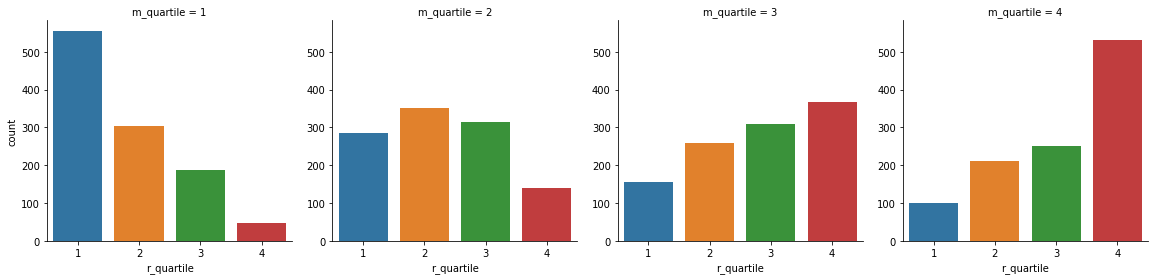

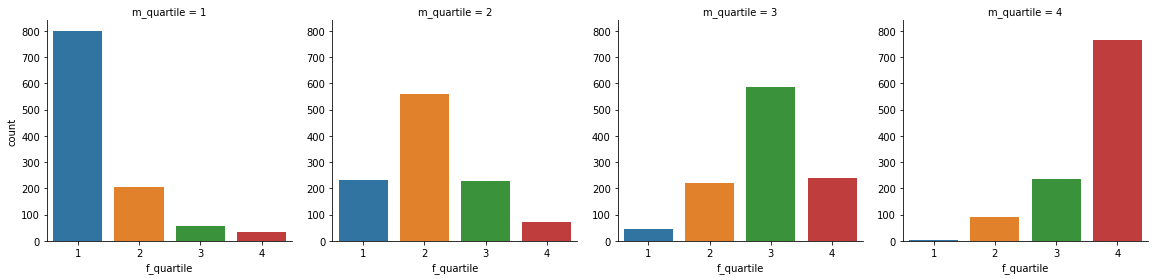

In [34]:
import seaborn as sns
cols = ['recency', 'frequency', 'monetary_value', 'm_quartile']
#sns.pairplot(segmented_rfm[cols], hue='m_quartile', size=2.5);
sns.factorplot(x='r_quartile', col='m_quartile', kind='count', data=segmented_rfm)
sns.factorplot(x='f_quartile', col='m_quartile', kind='count', data=segmented_rfm)

(array([ 1928.,   792.,   360.,   242.,   225.,   191.,   185.,   166.,
          144.,   139.]),
 array([   0. ,   37.3,   74.6,  111.9,  149.2,  186.5,  223.8,  261.1,
         298.4,  335.7,  373. ]),
 <a list of 1 Patch objects>)

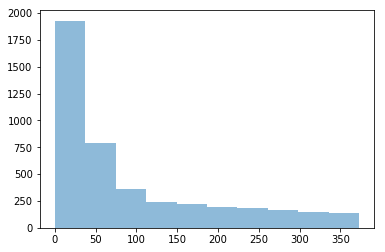

In [35]:
plt.hist(segmented_rfm.recency, bins=10, alpha=0.5, histtype='stepfilled')

## Exploration

In [90]:
from sklearn import preprocessing, decomposition, metrics, cluster
def PrepareDF(p_df, p_num, p_cat='', p_scale_all=False):
    if len(p_num) == 0:
        return pd.get_dummies(p_df[p_cat].astype(np.str))

    # Features numériques
    #scalingDF = preprocessing.scale(p_df[p_num])
    scalingDF = p_df[p_num]

    if len(p_cat) > 0:
        # Binarisation
        categDF = pd.get_dummies(p_df[p_cat].astype(np.str))
        X = pd.concat([scalingDF, categDF], axis=1)
    else:
        X = scalingDF
    print(X.columns)

    # Seules les xnum premières colonnes sont numériques
    xnum = scalingDF.shape[1]
    if p_scale_all:
        # Scaling de tout
        xnum = X.shape[1]
    x_numerical = X.iloc[:, 0:xnum]
    
    # Création d'un scaler pour les valeurs numériques 
    #scaler = preprocessing.StandardScaler()
    scaler = preprocessing.MinMaxScaler()

    # Qu'on entraine avec le training set
    scaler.fit(x_numerical) 
    x_numerical = scaler.transform(x_numerical)
    X = X.copy()
    X.loc[:, 0:xnum] = x_numerical
    return X
    
def GraphPCA(p_df):
    # 2 directions principales pour l'affichage
    pca = decomposition.PCA(n_components=2)
    pca.fit(p_df)
    print("Explained variance ratio :", pca.explained_variance_ratio_.cumsum())
    X_trans = pca.transform(p_df)
    
    fig = plt.figure(figsize=(16, 20))
    clstab = []
    for i in range(1, 11):
        # Avec i clusters
        cls = cluster.KMeans(n_clusters=i+1)
        cls.fit(p_df)
        ax = fig.add_subplot(4, 3, i)
        ax.scatter(X_trans[:, 0], X_trans[:, 1], c=cls.labels_)
        plt.title(str(i+1) + "clusters")
        clstab.append(cls)
    return clstab

Index(['Cancel', 'Promo', 'UK', 'Best', 'RFMScore_111', 'RFMScore_112',
       'RFMScore_113', 'RFMScore_114', 'RFMScore_121', 'RFMScore_122',
       'RFMScore_123', 'RFMScore_124', 'RFMScore_131', 'RFMScore_132',
       'RFMScore_133', 'RFMScore_134', 'RFMScore_141', 'RFMScore_142',
       'RFMScore_143', 'RFMScore_144', 'RFMScore_211', 'RFMScore_212',
       'RFMScore_213', 'RFMScore_221', 'RFMScore_222', 'RFMScore_223',
       'RFMScore_224', 'RFMScore_231', 'RFMScore_232', 'RFMScore_233',
       'RFMScore_234', 'RFMScore_241', 'RFMScore_242', 'RFMScore_243',
       'RFMScore_244', 'RFMScore_311', 'RFMScore_312', 'RFMScore_313',
       'RFMScore_314', 'RFMScore_321', 'RFMScore_322', 'RFMScore_323',
       'RFMScore_324', 'RFMScore_331', 'RFMScore_332', 'RFMScore_333',
       'RFMScore_334', 'RFMScore_341', 'RFMScore_342', 'RFMScore_343',
       'RFMScore_344', 'RFMScore_411', 'RFMScore_412', 'RFMScore_413',
       'RFMScore_421', 'RFMScore_422', 'RFMScore_423', 'RFMScore_424',
     

[KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max

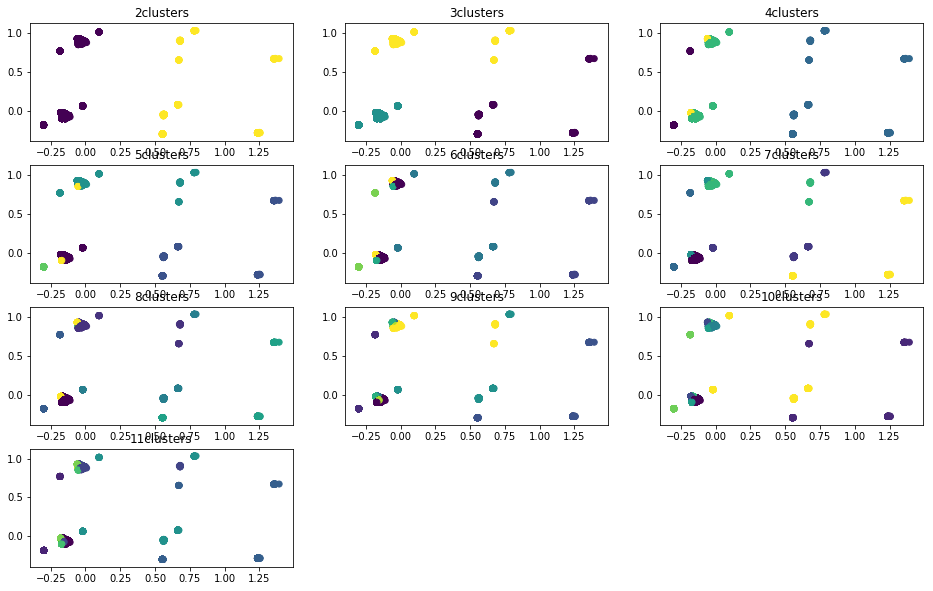

In [102]:
cols = ['recency', 'frequency', 'monetary_value']
cols = ['Cancel', 'Promo']
cols = []
cols = ['Cancel', 'Promo', 'UK', 'Best']

categories = ['RFMScore']
#categories = []

dfscaled = PrepareDF(segmented_rfm, cols, categories, False)
GraphPCA(dfscaled)

Index(['Cancel', 'Promo', 'UK', 'Best', 'RFMScore_111', 'RFMScore_112',
       'RFMScore_113', 'RFMScore_114', 'RFMScore_121', 'RFMScore_122',
       'RFMScore_123', 'RFMScore_124', 'RFMScore_131', 'RFMScore_132',
       'RFMScore_133', 'RFMScore_134', 'RFMScore_141', 'RFMScore_142',
       'RFMScore_143', 'RFMScore_144', 'RFMScore_211', 'RFMScore_212',
       'RFMScore_213', 'RFMScore_221', 'RFMScore_222', 'RFMScore_223',
       'RFMScore_224', 'RFMScore_231', 'RFMScore_232', 'RFMScore_233',
       'RFMScore_234', 'RFMScore_241', 'RFMScore_242', 'RFMScore_243',
       'RFMScore_244', 'RFMScore_311', 'RFMScore_312', 'RFMScore_313',
       'RFMScore_314', 'RFMScore_321', 'RFMScore_322', 'RFMScore_323',
       'RFMScore_324', 'RFMScore_331', 'RFMScore_332', 'RFMScore_333',
       'RFMScore_334', 'RFMScore_341', 'RFMScore_342', 'RFMScore_343',
       'RFMScore_344', 'RFMScore_411', 'RFMScore_412', 'RFMScore_413',
       'RFMScore_421', 'RFMScore_422', 'RFMScore_423', 'RFMScore_424',
     

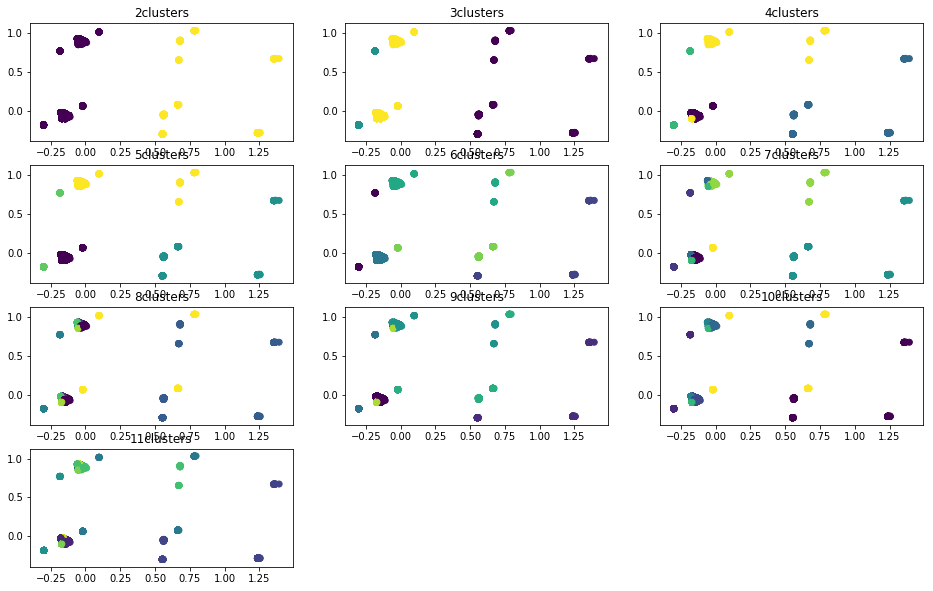

In [103]:
dflog = segmented_rfm.copy()
#dflog.recency = np.log(dflog.recency+1)
dflog.frequency = np.log(dflog.frequency+1)
dflog.monetary_value = np.log(dflog.monetary_value+1)

dflogscaled = PrepareDF(dflog, cols, categories)
clstab = GraphPCA(dflogscaled)

In [107]:
def SilhouetteGraph(p_df):
    sil = []
    nclust = range(2, 100)
    for nu in nclust:
        cls = cluster.KMeans(n_clusters=nu, n_init=1, init='random')
        cls.fit(p_df)
        si = metrics.silhouette_score(p_df, cls.labels_)
        sil.append(si)

    plt.figure(figsize=(10, 5))
    plt.plot(nclust, sil, marker='o')
    plt.xlabel("nb de clusters")
    plt.title("Coef de silhouette")

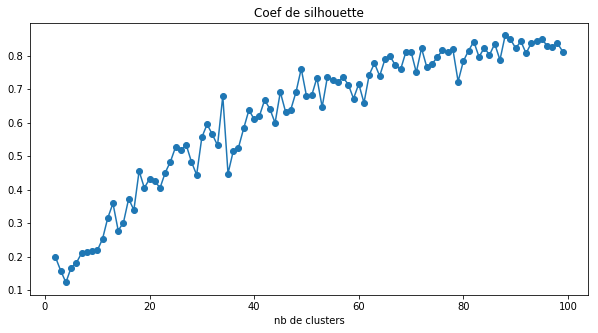

In [108]:
SilhouetteGraph(dfscaled)

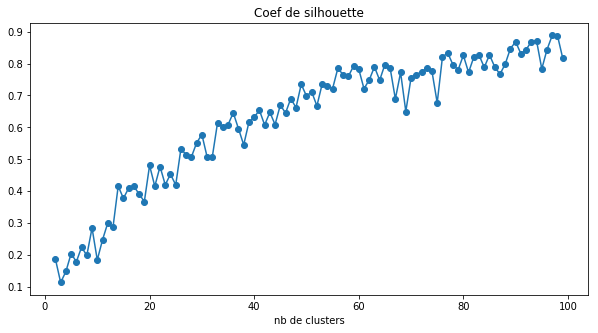

In [109]:
SilhouetteGraph(dflogscaled)

In [101]:
for i in range (1, 10):
    pca = decomposition.PCA(n_components=i)
    pca.fit(dfscaled)
    print("Explained variance ratio :", pca.explained_variance_ratio_.cumsum())


Explained variance ratio : [ 0.41407933]
Explained variance ratio : [ 0.41407933  0.75058352]
Explained variance ratio : [ 0.41407933  0.75058352  0.98691761]
Explained variance ratio : [ 0.41407933  0.75058352  0.98691761  0.99338059]
Explained variance ratio : [ 0.41407933  0.75058352  0.98691761  0.99338059  0.99670208]
Explained variance ratio : [ 0.41407933  0.75058352  0.98691761  0.99338059  0.99670208  0.9986375 ]
Explained variance ratio : [ 0.41407933  0.75058352  0.98691761  0.99338059  0.99670208  0.9986375   1.        ]


ValueError: n_components=8 must be between 0 and n_features=7 with svd_solver='full'

Etude des logs

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4372 entries, 14646.0 to 12346.0
Data columns (total 13 columns):
recency           4372 non-null float64
frequency         4372 non-null float64
monetary_value    4372 non-null float64
Cancel            4372 non-null int64
Promo             4372 non-null int64
UK                4372 non-null int64
cum_sum           4372 non-null float64
cum_perc          4372 non-null float64
Best              4372 non-null int64
r_quartile        4372 non-null int64
f_quartile        4372 non-null int64
m_quartile        4372 non-null int64
RFMScore          4372 non-null object
dtypes: float64(5), int64(7), object(1)
memory usage: 478.2+ KB


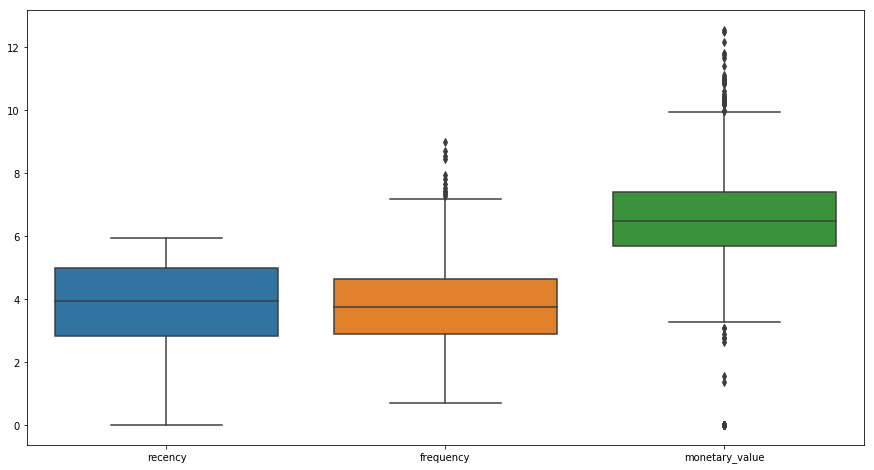

In [81]:
dflog = segmented_rfm.copy()
dflog.recency = np.log(dflog.recency+1)
dflog.frequency = np.log(dflog.frequency+1)
dflog.monetary_value = np.log(dflog.monetary_value+1)

test = dflog[['recency', 'frequency', 'monetary_value']]
fig = plt.figure(figsize=(15, 8))
sns.boxplot(data=test)
dflog.info()

Text(0.5,1,'k-means')

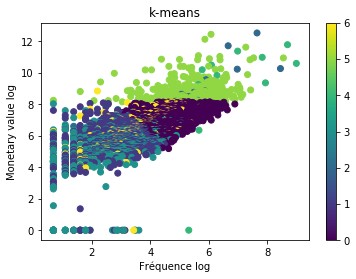

In [77]:
# Graphe avec 2 log de features et les couleurs de 6 clusters

plt.scatter(dflog.frequency, dflog.monetary_value, c=clstab[5].labels_)
plt.xlabel("Fréquence log")
plt.ylabel("Monetary value log")
plt.colorbar()
plt.title("k-means")

In [46]:
# Dataset avec série temporelle

dtTable = df[df.InvoiceDate.dt.month==8]
dtTable = dtTable[dtTable.InvoiceDate.dt.day<=20]
dtTable = dtTable.groupby('InvoiceDate').agg({'TotalPrice': lambda x: x.sum()})
#rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
dtTable

,TotalPrice
InvoiceDate,
2011-08-01 08:30:00,304.56
2011-08-01 09:31:00,178.50
2011-08-01 10:03:00,660.45
2011-08-01 10:08:00,211.14
2011-08-01 10:09:00,120.50
2011-08-01 10:23:00,799.62
2011-08-01 10:26:00,1089.18
2011-08-01 11:08:00,181.16
2011-08-01 11:12:00,8.29


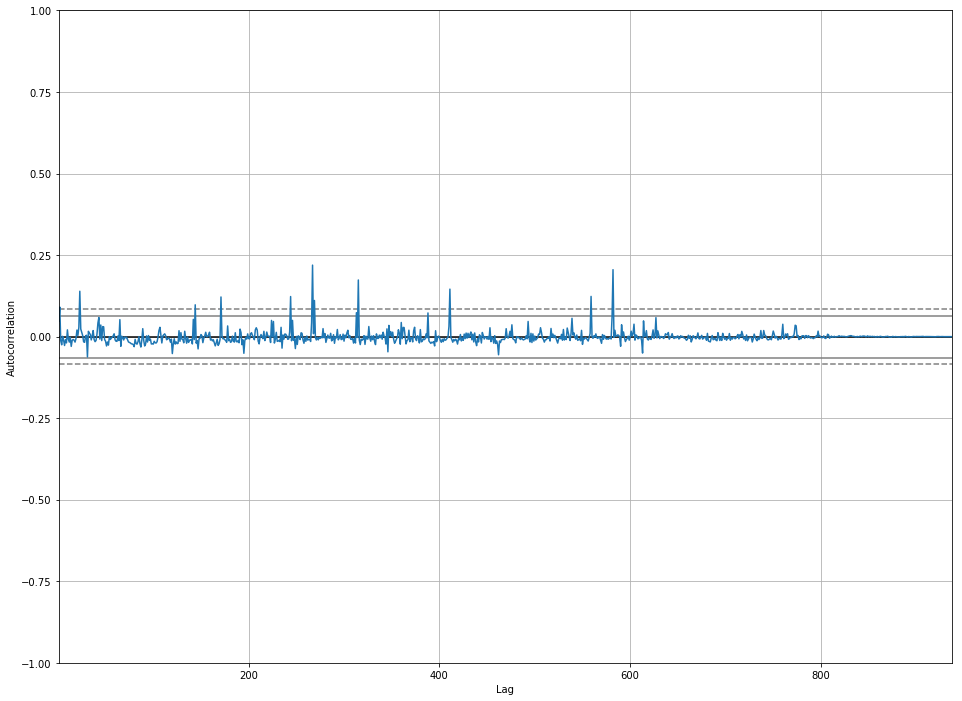

In [47]:
from pandas.plotting import autocorrelation_plot
fig = plt.figure(figsize=(16, 12))
autocorrelation_plot(dtTable)

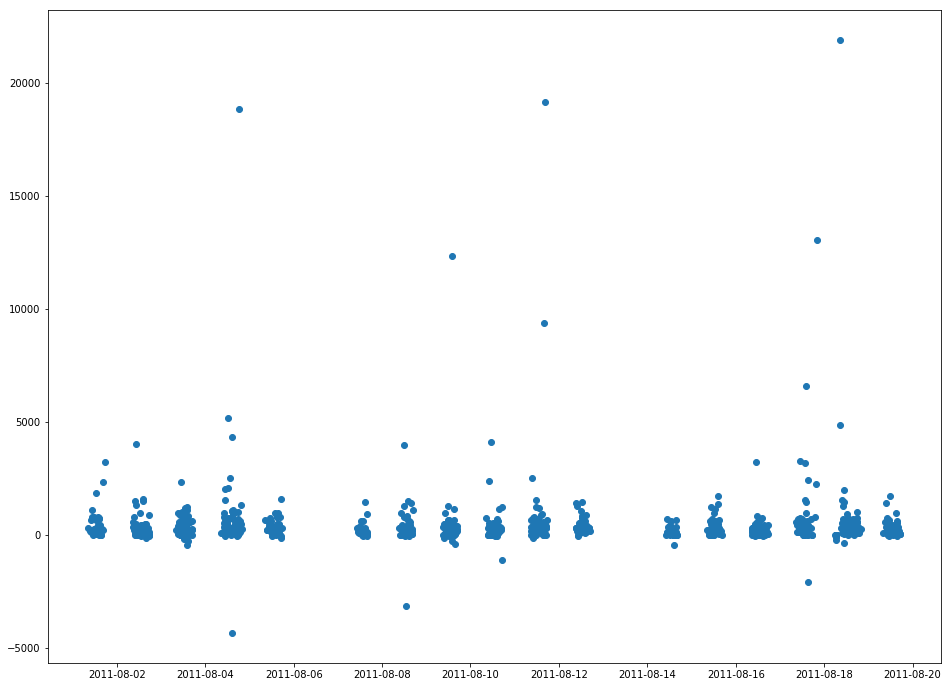

In [48]:
fig = plt.figure(figsize=(16, 12))

plt.plot_date(dtTable.index, dtTable)

## Modèle 2

In [50]:
df[df.CustomerID==17850]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,Promo,UK,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,0,1,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0,1,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,0,1,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0,1,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0,1,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,0,0,1,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,0,0,1,25.50
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,0,0,1,11.10
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,0,0,1,11.10
47,536372,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 09:01:00,1.85,17850.0,United Kingdom,0,0,1,11.10


In [126]:
tmp = df.copy()
tmp['InvoiceDateY'] = tmp['InvoiceDate'].dt.year
tmp['InvoiceDateM'] = tmp['InvoiceDate'].dt.month
#tmp = tmp.groupby(['CustomerID', 'InvoiceDateY', 'InvoiceDateM']).agg({'TotalPrice': lambda x: x.sum()})

tmp['InvoiceDateYM'] = tmp.apply(lambda row : (str(row['InvoiceDateY']) + '-' + str(row['InvoiceDateM'])), axis=1)
#tmp = tmp.groupby(['CustomerID', 'InvoiceDateM']).agg({'TotalPrice': lambda x: x.sum()})
tmp

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,Promo,UK,TotalPrice,InvoiceDateY,InvoiceDateM,InvoiceDateYM
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,0,1,15.30,2010,12,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0,1,20.34,2010,12,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,0,1,22.00,2010,12,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0,1,20.34,2010,12,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0,1,20.34,2010,12,2010-12
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,0,0,1,15.30,2010,12,2010-12
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,0,0,1,25.50,2010,12,2010-12
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,0,0,1,11.10,2010,12,2010-12
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,0,0,1,11.10,2010,12,2010-12
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,0,0,1,54.08,2010,12,2010-12


In [176]:
pd.set_option('display.max_columns', 200)
tmp2 = tmp.groupby(['CustomerID', 'InvoiceDateM', 'InvoiceDateY']).agg({'TotalPrice': lambda x: x.sum()}).unstack().unstack()
tmp2.head()

TotalPrice                                                  \
InvoiceDateY       2010                                                   
InvoiceDateM         1   2   3   4   5   6   7   8   9   10  11      12   
CustomerID                                                                
12346.0             NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN     NaN   
12347.0             NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  711.79   
12348.0             NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  892.80   
12349.0             NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN     NaN   
12350.0             NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN     NaN   

                                                                        \
InvoiceDateY    2011                                                     
InvoiceDateM      1      2   3       4   5       6   7       8      9    
CustomerID                                                               
12346.0         0.00    NaN NaN     NaN NaN     NaN NaN     NaN    NaN   
12347.0       475.39    NaN NaN  636.25 NaN  382.52 NaN  584.91    NaN   
12348.0       227.44    NaN NaN  367.00 NaN     NaN NaN     NaN  310.0   
12349.0          NaN    NaN NaN     NaN NaN     NaN NaN     NaN    NaN   
12350.0          NaN  334.4 NaN     NaN NaN     NaN NaN     NaN    NaN   

                                        
InvoiceDateY                            
InvoiceDateM       10       11      12  
CustomerID                              
12346.0           NaN      NaN     NaN  
12347.0       1294.32      NaN  224.82  
12348.0           NaN      NaN     NaN  
12349.0           NaN  1757.55     NaN  
12350.0           NaN      NaN     NaN

In [177]:
tmp2 = tmp2.iloc[:,-13:-1]
tmp2['Target'] = (tmp2.iloc[:,-1] > 0)
tmp2.head(10)

TotalPrice                                                     \
InvoiceDateY       2010    2011                                              
InvoiceDateM         12       1      2   3       4   5       6   7       8   
CustomerID                                                                   
12346.0             NaN    0.00    NaN NaN     NaN NaN     NaN NaN     NaN   
12347.0          711.79  475.39    NaN NaN  636.25 NaN  382.52 NaN  584.91   
12348.0          892.80  227.44    NaN NaN  367.00 NaN     NaN NaN     NaN   
12349.0             NaN     NaN    NaN NaN     NaN NaN     NaN NaN     NaN   
12350.0             NaN     NaN  334.4 NaN     NaN NaN     NaN NaN     NaN   

                                      Target  
InvoiceDateY                                  
InvoiceDateM      9       10       11         
CustomerID                                    
12346.0         NaN      NaN      NaN  False  
12347.0         NaN  1294.32      NaN  False  
12348.0       310.0      NaN      NaN  False  
12349.0         NaN      NaN  1757.55   True  
12350.0         NaN      NaN      NaN  False

In [181]:
tmp2 = tmp2.fillna(0)
from sklearn.model_selection import train_test_split
X = tmp2.iloc[:, :-1]
y = tmp2.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [190]:
from sklearn import dummy
# Méthode naive par la classe la plus fréquente pour comparer
dum = dummy.DummyClassifier(strategy='most_frequent')
# Entraînement
dum.fit(X_train, y_train)
# Prédiction sur le jeu de test
y_pred = dum.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print (roc_auc)
# Evaluate
print ("Méthode naive : MSE = %.2f" % metrics.mean_squared_error(y_test, y_pred))

0.5
Méthode naive : MSE = 0.38


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:239: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,


In [186]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
lr = LogisticRegression()
lr.fit(X_train,y_train)
# On récupère la prédiction de la valeur positive
y_pred = lr.predict_proba(X_test)[:,1] 
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print (roc_auc)
print ("LogisticRegression : MSE = %.2f" % metrics.mean_squared_error(y_test, y_pred))

0.997137385097
LogisticRegression : MSE = 0.01


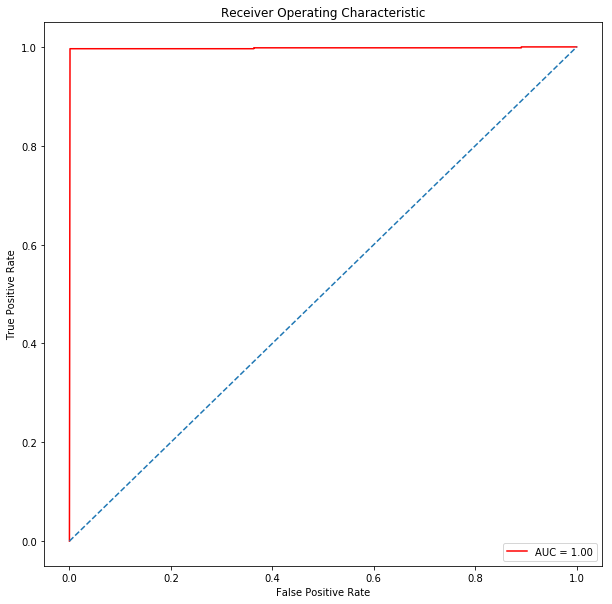

In [185]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [197]:
pd.concat(X_test, y_test)

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"